# ModelSelection.ipynb
## Choosing the number of states for hidden Markov models

Give place field plots for m=15, m=30, m=45, m=60 to show that in each case, we learn behaviorally relevant place field representations.

Here I will demonstrate two ways to order states of a hidden Markov model, with a key assumption being that cells/units have no defined topography/topology. That is, in the hippocampus, (place) cells are recruited at random, and neighboring place cells are not guaranteed to have adjacent or even nearby place fields. This lack of cellular topology motivates us to use the Hellinger distance, described later, whereas if the cellular topology _is_ important, then we can consider something like the Wasserstein (earth mover's) distance instead.

First, it should be obvious that state labels from a hidden Markov model are arbitrary, and the model itself does not impose any ordering on the set of states. However, in practice we may very well be interested to know that states $i$ and $j$ are "closer" to each other than states $i$ and $k$, for example.

The first ordering approach I will consider, is based simply on a greedy re-ordering of the states based on their transition probabilities. We start with any state, say $S_0=i$, and then greedily select the next state, which has highest probability of occurence after $i$, and so on. This ordering is not necessarily optimal in any sense, but it should be close to optimal in many ways that make sense. However, two limitations to such an approach include the (i) linear ordering, and the (ii) lack of distance information. For example, if we have a T-maze, then what ordering should we choose? At some point, the greedy algorithm might be forced to group two states together that are nowhere close to each other. Second, we have no information to know how much closer two adjacent states are to each other than to a neighbor one or two spaces removed.

Both of the above limitations can be mitigated to some extent by using multidimensional scaling (MDS), Isomap, or some similar techniques. Here I consider MDS, where we attempt to find an optimal embedding of the states in a 2-dimensional or a 1-dimensional space, depending on our belief about the underlying environment. 

In particular, I use the Hellinger distance to compute point-wise distances between different state-unit pairs. For example, for any pair of states $S_A$ and $S_B$ and an associated unit $u$, we have Poisson firing rates $u_A$ and $u_B$, so that we compute the squared Hellinger distance between these Poisson distributions as
$$
H^2\bigl(S_A(u),S_B(u)\bigr) = 1-\exp\biggl(-\frac{1}{2}\bigl(\sqrt{u_A} - \sqrt{u_B}\bigr)^2\biggr).
$$
Then we simply consider the pairwise distance between the two states as the average Hellinger distance over all the units:
$$
D(S_A,S_B) = \dfrac{1}{|U|}\sum_{u \in U} H\bigl(S_A(u), S_B(u) \bigr).
$$

Using $D$ as our distance function in MDS and projecting the data onto a 1-dimensional subspace then reveals both an ordering for the states, as well as approximate distances between those states, allowing us to make observations such as "state $i$ is much more similar to state $j$ than it is to state $k$," and so on. Of course, if we project it onto a 2-dimensional subspace, then we could potentially learn even more about the state associations, in that we can learn about state adjecency and proximity even when the underlying states cannot be described by a simple linear ordering.

**Idea:** Perhaps I should simulate this with a T or 3-arm maze (or even an $N$-arm maze) and show how the state associations can reveal the nonexistence of a suitable linear ordering.

**Remark:** The above approaches have been designed with the assumption that we need to do this in a completely unsupervised manner. Of course, if we actually have some position data for the animals, we can create a heatmap of the decoded states, allowing us to assign the states to the modes of their spatial distributions. This idea is not demonstrated here.


### Import packages and initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import klabtools as klab
import seqtools as sq

import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

%matplotlib inline

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1.5})
sns.set_style("white")

function saveFigure(filename) loaded

Tip: to save a figure, call saveFigure("path/figure.pdf")


### Load data
Here we consider lin2 data for gor01 on the first recording day (6-7-2006), since this session had the most units (91) of all the gor01 sessions, and lin2 has position data, whereas lin1 only has partial position data.

In [2]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=False)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=False)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=False)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=False,verbose=False)

reading position data from 'C:\etienne\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'


In [3]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

## identify boundaries for running (active) epochs and then bin those observations into separate sequences:
runbdries = klab.get_boundaries_from_bins(eeg.samprate,bins=speed.active_bins,bins_fs=60)
binned_spikes_bvr = klab.bin_spikes(spikes.data, fs=spikes.samprate, boundaries=runbdries, boundaries_fs=eeg.samprate, ds=ds)

## stack data for hmmlearn:
seq_stk_bvr = sq.data_stack(binned_spikes_bvr, verbose=True)
seq_stk_all = sq.data_stack(binned_spikes, verbose=True)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_bvr, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmm = sq.hmm_train(tr_b, num_states=35, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
90 sequences being stacked...
Total sequence length: 1938 bins, each of width 0.125 seconds
Successfully stacked 90 sequences for a total of 242.25 seconds of data.
Only one sequence in data; so data is already in stacked format...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1163 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 145.38 seconds of data.
9 sequences being stacked...
Total sequence length: 174 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.75 seconds of data.
27 sequences being stacked...
Total sequence length: 601 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 75.12 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


## Approach 1: linear ordering of states using the state transition probability matrix
Here we sort states in a greedy manner using the state transition probability matrix. We can choose an arbitrary state as our first state, and then greedily select the most likely state to follow our first state, followed by the most likely state from the remaining unsorted states, and so on. 

We will use RUN > 8 data to train an $m=35$ state HMM. This number of states might not be optimal (indeed, we can optimize this parameter for any given dataset using a validation set), but we have also previously shown that the number of states does not make a big difference in the model performance. That is, the analyses are fairly insensitive to the actual number of states, which is a very good thing. Anything from around $m=25$ to $m=50$ could make sense, but we can get meaningful results even for $m=10$ state models.

In [4]:
# sort model states:
def get_sorted_order_from_transmat(A, start_state = 0):
    
    new_order = [start_state]
    num_states = A.shape[0]
    rem_states = np.arange(0,start_state).tolist()
    rem_states.extend(np.arange(start_state+1,num_states).tolist())
    cs = start_state

    for ii in np.arange(0,num_states-1):
        nstilde = np.argmax(A[cs,rem_states])
        ns = rem_states[nstilde]
        rem_states.remove(ns)
        cs = ns
        new_order.append(cs)
        
    return new_order, A[:, new_order][new_order]

new_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state = 17)

[]

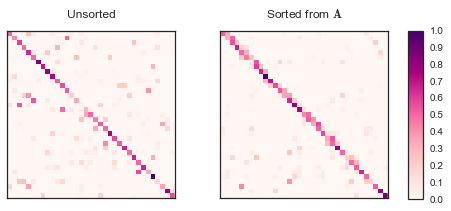

In [5]:
myhmm.transmat_.sum(axis=1) # confirm orientation of transition prob matrix
A = myhmm.transmat_.copy()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
im = ax1.matshow(A, interpolation='none', cmap='RdPu')
ax2.matshow(Anew, interpolation='none', cmap='RdPu')
# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.93, 0.12, 0.03, 0.78])
fig.colorbar(im, cax=cax)
ax1.set_title('Unsorted')
ax2.set_title('Sorted from $\mathbf{A}$')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

**Remarks:** First notice that the state transition probability matrix is almost diagonal. However, after sorting, we can see the banded structure, showing the strong Markovian dynamics of the underlying data.

We might be interested to know how much better sequences look after this greedy rearrangement? To illustrate the difference, we will show sequences from the RUN test set (never before seen by the model) both before and after sorting.

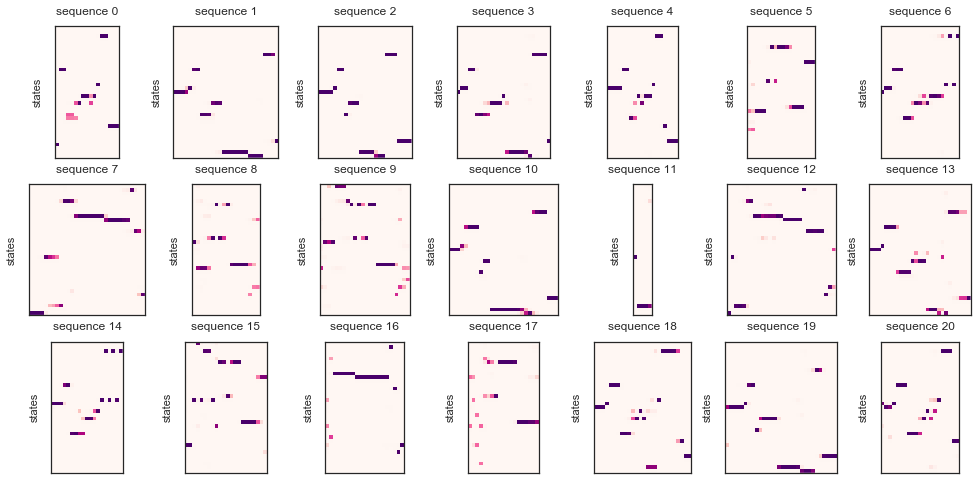

In [6]:
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp), interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')


Now we show the same sequences after applying our new ordering:

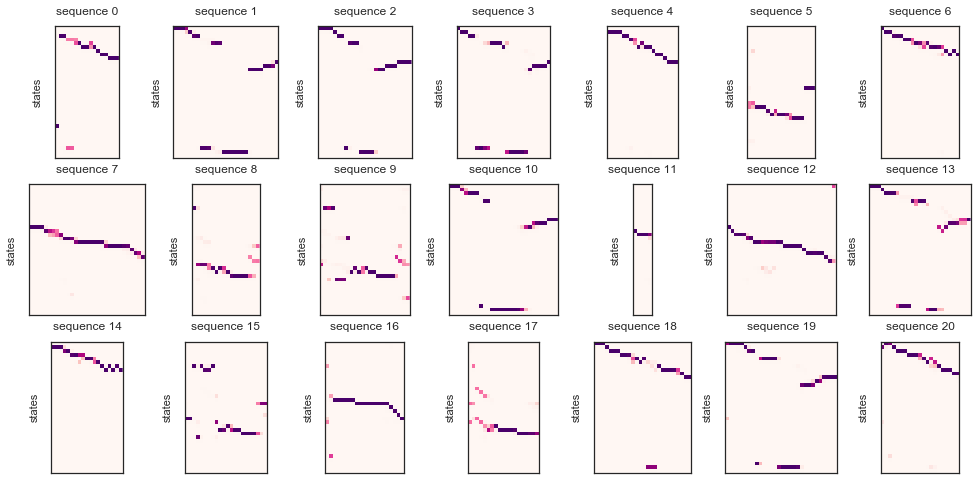

In [7]:
start_state = 17

new_order, Anew = get_sorted_order_from_transmat(myhmm.transmat_, start_state=start_state)
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[new_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')


**Remarks:** We can clearly see that the second ordering is better, in the sense that sequential structures are more apparent. The ordering (or the decoding) is not perfect however, which may be due to the greedy nature of the ordering, or simply variability in the neural signals.

Here choosing a good ```starting_state``` can also influence the visual results, but thankfully neither the ordering, nor the ```starting_state``` should affect our analyses in general.

### What about ordering the states based on their peak locations on the track? (Assuming pos data known)
**Warning:** The results below highlight a part of my codebase that I need to re-write. In particular, when I bin data for analysis, I can take two approaches: (i) find eeg sample numbers for which the animal was running above threshold, and then find the smallest number of bins to cover each segment, or (ii) bin all the data, and extract the bins for which the animal was running above threshold.

The first approach gives a finer scale for starting sequences, but it makes it hard to do some other parts of my analyses because of how my code has been designed (getting the true position, for one thing...). In this approach, it is also not a trivial matter to take the complement of the running bins, since the complement will most likely not be an integral multiple of the bin size. It is also much slower to compute as compared to binning all the data, and then extracting relevant bins.

However, training data on the pre-binning approach (which we do below) gives strange state sequences. I did not notice this when looking at the place fields, where I also used such a binning approach, and technically there is nothing _wrong_ with what I see, but it is not what I _wanted_ to see. **What is going on? Why the difference? How should I re-write my code to make the two approaches more similar?**

**UPDATE:** See the remarks at the end of this section for a possible explanation and intuition of what's going on here, and why it may not be a problem.

In [8]:
from mymap import Map

def extract_subsequences_from_binned_spikes(binned_spikes, bins):
    data = spikes.data.copy()
    boundaries = klab.get_continuous_segments(bins)
    
    binned = Map()
    binned['bin_width'] = binned_spikes.bin_width
    binned['data'] = binned_spikes.data[bins,:]
    binned['boundaries'] = boundaries
    binned['boundaries_fs'] = 1/binned_spikes.bin_width   
    binned['sequence_lengths'] = (boundaries[:,1] - boundaries[:,0] + 1).flatten()
    
    return binned

In [9]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

centerx = (np.array(posdf['x1']) + np.array(posdf['x2']))/2
centery = (np.array(posdf['y1']) + np.array(posdf['y2']))/2

tend = len(speed.data)/speed.samprate # end in seconds
time_axis = np.arange(0,len(speed.data))/speed.samprate
speed_125, tvel_125 = klab.resample_velocity(velocity=speed.data,t_bin=ds,tvel=time_axis,t0=0,tend=tend)
truepos_125 = np.interp(np.arange(0,len(binned_spikes.data))*ds,time_axis,centerx)

# get bins where rat was running faster than thresh units per second
runidx_125 = np.where(speed_125>8)[0]
seq_stk_run_125 = extract_subsequences_from_binned_spikes(binned_spikes,runidx_125)

## split data into train, test, and validation sets:
tr_b2,vl_b2,ts_b2 = sq.data_split(seq_stk_run_125, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmm2 = sq.hmm_train(tr_b2, num_states=35, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1135 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 141.88 seconds of data.
9 sequences being stacked...
Total sequence length: 170 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.25 seconds of data.
27 sequences being stacked...
Total sequence length: 591 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 73.88 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


In [10]:
###########################################################3
stacked_data = seq_stk_run_125
###########################################################3

x0=0; xl=100; num_pos_bins=50
xx_left = np.linspace(x0,xl,num_pos_bins+1)
num_sequences = len(stacked_data.sequence_lengths)
num_states = myhmm.n_components
state_pos = np.zeros((num_states, num_pos_bins))

for seq_id in np.arange(0,num_sequences):
    tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm2.score_samples(obs)
    xx = truepos_125[stacked_data.boundaries[seq_id,0]:stacked_data.boundaries[seq_id,1]+1]
    digitized = np.digitize(xx, xx_left) - 1 # spatial bin numbers
    for ii, ppii in enumerate(pp):
        state_pos[:,digitized[ii]] += np.transpose(ppii)

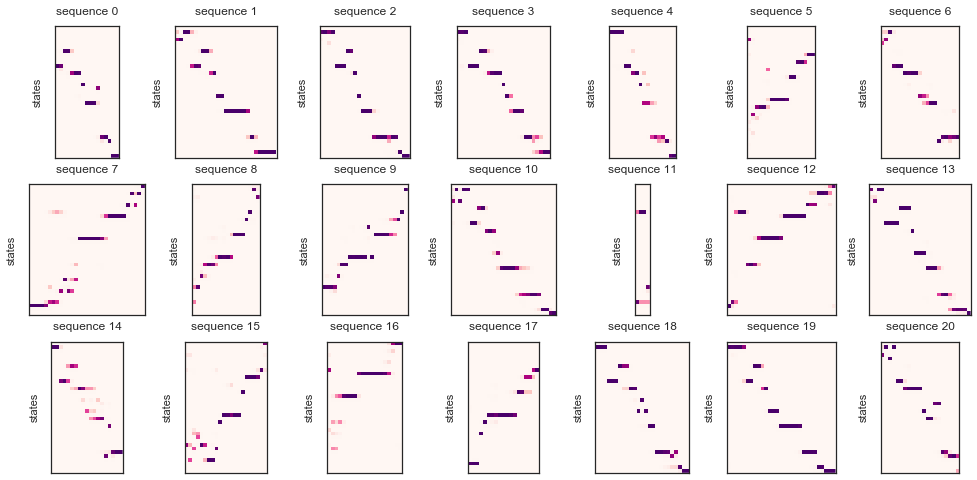

In [11]:
## now order states by peak location on track
peaklocations = state_pos.argmax(axis=1)
peak_order = peaklocations.argsort()

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b2.sequence_lengths).tolist());

fig, axes = plt.subplots(3, 7, figsize=(17, 8))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b2.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm2.score_samples(obs)
    ax.matshow(np.transpose(pp)[peak_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')


**Remarks:** Apart from the strange ?sparseness? of my state sequences, we do see clear continuity for all the sequences considered when ordering by the peak locations of the learned place fields. I am really anxious to understand why my state distributions are so different than when I take the alternative post-binning approach as opposed to the pre-binning approach taken here.

**Possible explanation:** Perhaps this state-sparseness shouldn't make me too worried—perhaps it is really simply due to the peak ordering of the states? So if the animal runs faster than the typical state-to-state transitions, then the above sequences actually make a lot of sense.

For example, $S_1 \rightarrow S_4 \rightarrow S_7$ and $S_2 \rightarrow S_5 \rightarrow S_8$ could look like the above sequences, where the peak ordering would be $(S_1,S_2,\ldots, S_8)$, whereas the state adjacency ordering would be different, such that $(S_1,S_4,S_7)$ and $(S_2,S_5,S_7)$ should appear somewhere in the ordering.

This observation might actually also help explain why some sequences in the state transition probability matrix ordered approach appear continuous, while other appear only piece-wise continuous.

## Approach 2: generalized state associations using multidimensional scaling (MDS)
Here we will consider MDS using Hellinger (expect to work well) and Euclidean distances (expect to work less well).

For a comparison between some of the different alternatives, consider looking at
* http://scikit-learn.org/stable/modules/manifold.html#manifold-learning and
* http://www.cs.cmu.edu/~efros/courses/AP06/presentations/melchior_isomap_demo.pdf

**Note:** The purpose of the MDS is to find a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space, unlike other manifold-learning algorithms, it does not seek an isotropic representation of the data in the low-dimensional space. Isomap might be conceptually more appealing, especially for recovering the topology of an environment...

In [ ]:
#def normalize_tuning_curves(state_pos):
#    num_states = state_pos.shape[0]
#    num_pos_bins = state_pos.shape[1]
#    state_pos = state_pos / np.tile(np.reshape(state_pos.sum(axis=1),(num_states,1)),num_pos_bins)
#    return state_pos

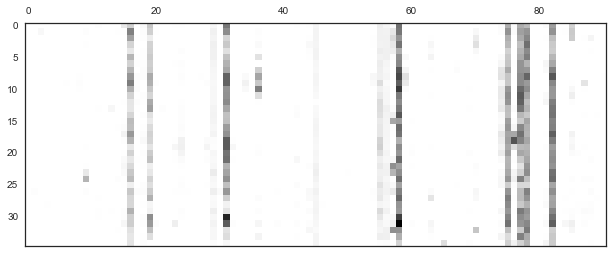

In [21]:
plt.matshow(myhmm.means_[new_order,:])
#myhmm.means_.sum(axis=1)

In [ ]:
def plot_tuning_curves(tmat)


In [96]:
similarities = euclidean_distances(myhmm.means_)
similarities.shape


(35, 35)

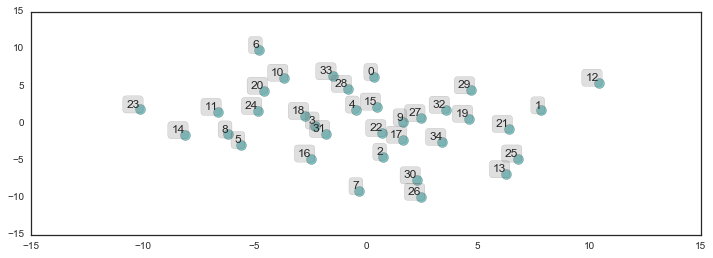

In [136]:
from sklearn import manifold
from sklearn.metrics import euclidean_distances

num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities).embedding_

labels = ['{0}'.format(i) for i in range(num_states)]
plt.scatter(pos[:, 0], pos[:, 1], s=100, c='DarkCyan', alpha=0.5)

for label, x, y in zip(labels, pos[:, 0], pos[:, 1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (0, 0),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round', fc = 'gray', alpha = 0.25))

plt.show()

In [157]:
num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

mds = manifold.MDS(n_components=1, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities).embedding_

#labels = ['{0}'.format(i) for i in range(num_states)]
#plt.plot(pos, c='DarkCyan', alpha=0.5)

#plt.show()

vals = np.array([x[0] for x in pos])
sort_index = np.argsort(vals)

print(sort_index)

[12 26 13 25  1 14 29 21 32 17 19 34  9  5 27 22 31 15  4  2 18 24 28  8  3
  0 11 20 33 16 10 30  7  6 23]


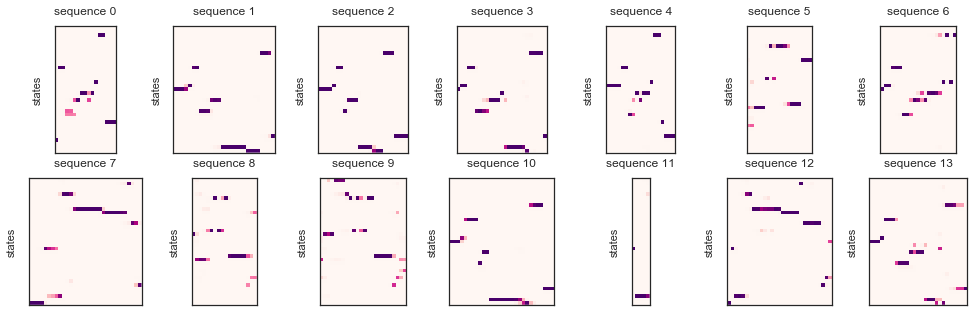

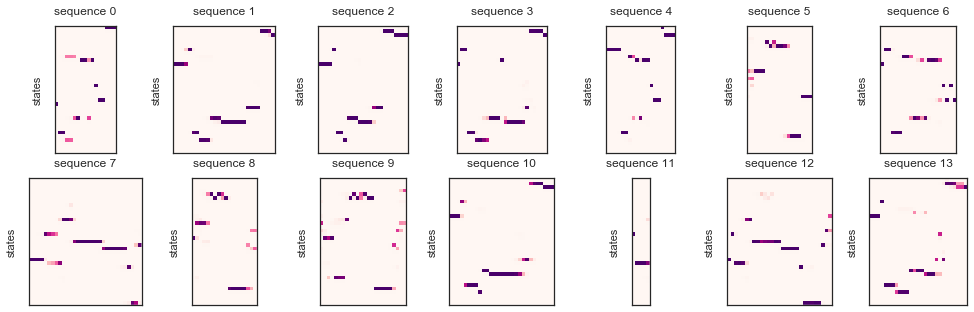

In [199]:
num_states = myhmm.n_components
similarities = euclidean_distances(myhmm.means_)

mds = manifold.MDS(n_components=1, max_iter=3000, eps=1e-9, random_state=seed,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(similarities).embedding_

#labels = ['{0}'.format(i) for i in range(num_states)]
#plt.plot(pos, c='DarkCyan', alpha=0.5)

#plt.show()

vals = np.array([x[0] for x in pos])
sort_index = np.argsort(vals)

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(2, 7, figsize=(17, 5))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp), interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')

fig2, axes2 = plt.subplots(2, 7, figsize=(17, 5))
axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes2):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[sort_index,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')

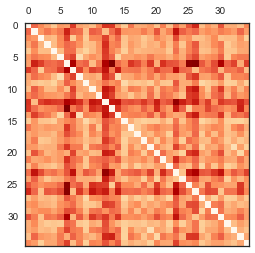

In [200]:
plt.matshow(similarities, cmap='OrRd')

**Conclusion:** MDS with Euclidean dist = bad

In [194]:
def poisson_hellinger_distances(tmat):
    # tmat is N x p : N observations in a p-dimensional space
    N, p = tmat.shape
    D = np.zeros((N,N))
    sqrtmat = np.sqrt(tmat)
    
    for ii in np.arange(0, N):
        for jj in np.arange(ii, N):
            D[ii,jj] = np.sqrt(1 - np.exp(-0.5*(sqrtmat[ii,:] - sqrtmat[jj])**2)).sum()
            D[jj,ii] = D[ii,jj]
    return D

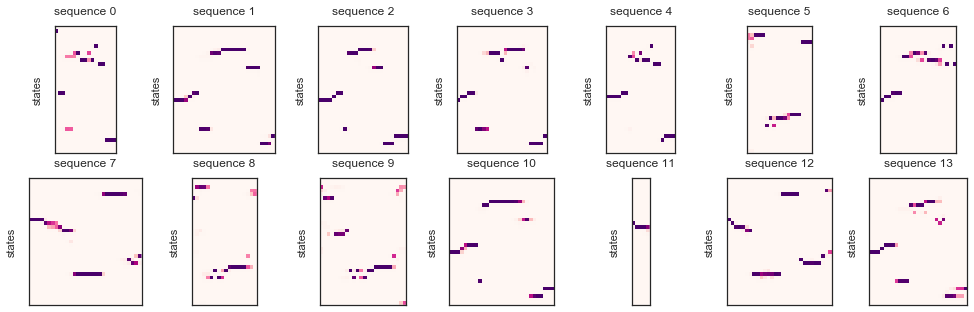

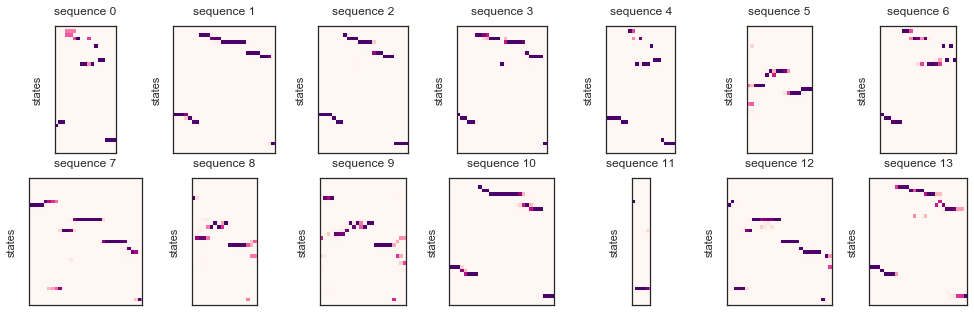

In [251]:
start_state += 1

num_states = myhmm.n_components

similaritiesPH = poisson_hellinger_distances(myhmm.means_)
similaritiesED = euclidean_distances(myhmm.means_)

similaritiesPH = similaritiesPH/similaritiesPH.max()
similaritiesED = similaritiesED/similaritiesED.max()

new_orderPH, matPH = get_sorted_order_from_transmat(1-similaritiesPH, start_state=start_state)
new_orderED, matED = get_sorted_order_from_transmat(1-similaritiesED, start_state=start_state)

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());

fig, axes = plt.subplots(2, 7, figsize=(17, 5))
axes = [item for sublist in axes for item in sublist]

for ii, ax in enumerate(axes):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[new_orderED,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')

fig2, axes2 = plt.subplots(2, 7, figsize=(17, 5))
axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes2):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[new_orderPH,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')

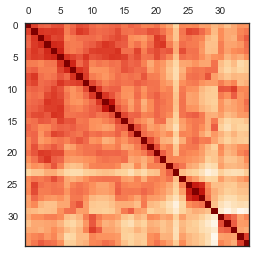

In [252]:
plt.matshow(matED, cmap='OrRd')

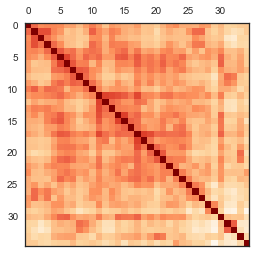

In [253]:
plt.matshow(matPH, cmap='OrRd')

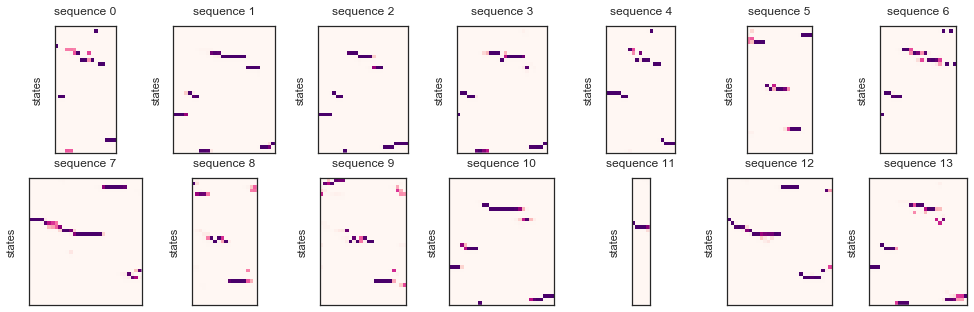

In [242]:
similarities = similarities/similarities.max()

start_state = 0

new_order, Anew = get_sorted_order_from_transmat(1-similarities, start_state=start_state)

fig2, axes2 = plt.subplots(2, 7, figsize=(17, 5))
axes2 = [item for sublist in axes2 for item in sublist]

for ii, ax in enumerate(axes2):
    obs = ts_b.data[tmpseqbdries[ii]:tmpseqbdries[ii+1],:]
    ll, pp = myhmm.score_samples(obs)
    ax.matshow(np.transpose(pp)[new_order,:], interpolation='none', cmap='RdPu')
    #ax.axison = False
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title('sequence ' + str(ii))
    ax.set_ylabel('states')

In [238]:
similarities = similarities/similarities.max()